In [1]:
# 0 define backend
import sys, os, time

# %env DDE_BACKEND=tensorflow.compat.v1
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf

os.environ['DDE_BACKEND'] = "tensorflow" # v2
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf"

# https://stackoverflow.com/questions/68614547/tensorflow-libdevice-not-found-why-is-it-not-found-in-the-searched-path
# this directory has /nvvm/libdevice/libdevice.10.bc

print(os.environ['DDE_BACKEND'])

tensorflow


In [2]:
import tensorflow as tf

import deepxde as dde
import numpy as np
from numpy import linalg as LA
import math

import matplotlib.pyplot as plt
import pylab

from os.path import dirname, join as pjoin

from scipy import stats
import scipy.io
from scipy.stats import truncnorm, norm
from scipy.optimize import linprog
from scipy import sparse
from scipy.stats import multivariate_normal

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    
if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp

Using backend: tensorflow

2022-09-09 13:16:40.480655: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-09 13:16:40.480729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vipersim01.ndc.nasa.gov
2022-09-09 13:16:40.480751: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vipersim01.ndc.nasa.gov
2022-09-09 13:16:40.480906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-09 13:16:40.480962: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-09 13:16:40.480978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


In [3]:
import cvxpy as cp
import numpy as np
import tensorflow as tf
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm
from cvxpylayers.tensorflow.cvxpylayer import CvxpyLayer

print(time.time())

1662754608.1453207


In [95]:
N = nSample = 100

# must be floats
state_min = 0.0
state_max = 6.0

j1, j2, j3 =1,1,2 # axis-symmetric case
q_statepenalty_gain = 0 # 0.5

T_0=0. #initial time
T_t=200. #Terminal time

print(time.time())

1662755250.0594432


In [73]:
x_T = np.transpose(np.linspace(state_min, state_max, N))
y_T = np.transpose(np.linspace(state_min, state_max, N))
z_T = np.transpose(np.linspace(state_min, state_max, N))
x_T=x_T.reshape(len(x_T),1)
y_T=y_T.reshape(len(y_T),1)
z_T=z_T.reshape(len(z_T),1)
print(time.time())

1662755143.65835


In [96]:
def pdf1d(x, mu, sigma):
    a, b = (state_min - mu) / sigma, (state_max - mu) / sigma
    rho_x=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)

    # do NOT use gaussian norm, because it is only area=1
    # from -inf, inf, will not be for finite state/grid
    # rho_x = norm.pdf(x, mu, sigma)
    return rho_x

def boundary(_, on_initial):
    return on_initial

print(time.time())

1662755277.6753075


1662754617.398471


In [151]:
x_grid = np.transpose(np.linspace(state_min, state_max, nSample))
y_grid = np.transpose(np.linspace(state_min, state_max, nSample))
[X,Y] = np.meshgrid(x_grid,x_grid)
C = (X - Y)**2

# cvector = C.flatten('F')
cvector = C.reshape(nSample**2,1)

A = np.concatenate(
    (
        np.kron(
            np.ones((1,nSample)),
            sparse.eye(nSample).toarray()
        ),
        np.kron(
            sparse.eye(nSample).toarray(),
            np.ones((1,nSample))
        )
    ), axis=0)
# 2*nSample

print(cvector.shape)
print(A.shape)

(10000, 1)
(200, 10000)


In [153]:
# 1d linprog example

rho_0_1d=pdf1d(x_T, 5.0, 1.0).reshape(len(x_T),1)
rho_T_1d=pdf1d(x_T, 4.0, 1.0).reshape(len(x_T),1)

rho_0_1d = np.where(rho_0_1d < 0, 0, rho_0_1d)
rho_0_1d = rho_0_1d / np.sum(np.abs(rho_0_1d))

# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)[0]
# rho_0_1d = rho_0_1d / rho_0_1d_trapz
# rho_0_1d_trapz = np.trapz(rho_0_1d, axis=0)
# print("rho_0_1d_trapz=",rho_0_1d_trapz)

rho_T_1d = np.where(rho_T_1d < 0, 0, rho_T_1d)
rho_T_1d = rho_T_1d / np.sum(np.abs(rho_T_1d))

# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)[0]
# rho_T_1d = rho_T_1d / rho_T_1d_trapz
# rho_T_1d_trapz = np.trapz(rho_T_1d, axis=0)
# print("rho_T_1d_trapz=",rho_T_1d_trapz)

rho_0 = rho_0_1d
rho_T = rho_T_1d

print(time.time())

1662770078.1267629


In [120]:
res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    bounds=[(0, np.inf)],
    options={"disp": True}
)
print(res.fun)

Running HiGHS 1.2.2 [date: 2022-08-30, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
200 rows, 10000 cols, 20000 nonzeros
199 rows, 10000 cols, 19900 nonzeros
Presolve : Reductions: rows 199(-1); columns 10000(-0); elements 19900(-100)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 199(1.99666) 0s
       2699     6.3187344716e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2699
Objective value     :  6.3187344716e-01
HiGHS run time      :          0.13
0.6318734471629914


In [122]:
# Define and solve the CVXPY problem.
x = cp.Variable(
    cvector.shape[0],
    nonneg=True
)
prob = cp.Problem(
    cp.Minimize(cvector.T @ x),
    [
        A @ x == np.concatenate((
            rho_0,
            rho_T
        ), axis=0).reshape(-1),
        # do NOT specify bounds constraints here
    ],
)
prob.solve(verbose=False)

# Print result.
print("\nThe optimal value is", prob.value)

# print("A dual solution is")
# print(prob.constraints[0].dual_value)


The optimal value is 0.6318734626810212


In [123]:
# Generate data
tf.random.set_seed(1)
np.random.seed(1)

n = 2
m = 3

A = np.eye(n) + 1e-2 * np.random.randn(n, n)
B = 1e-2 / 3 * np.random.randn(n, m)
Q = np.eye(n)
R = np.eye(m)

# Compute LQR control policy
P_lqr = solve_discrete_are(A, B, Q, R)
P = R + B.T@P_lqr@B
P_sqrt_lqr = sqrtm(P)

# Construct CVXPY problem and layer
x_cvxpy = cp.Parameter((n, 1))
P_sqrt_cvxpy = cp.Parameter((m, m))
P_21_cvxpy = cp.Parameter((n, m))
q_cvxpy = cp.Parameter((m, 1))

u_cvxpy = cp.Variable((m, 1))
y_cvxpy = cp.Variable((n, 1))

objective = .5 * cp.sum_squares(P_sqrt_cvxpy @ u_cvxpy) + x_cvxpy.T @ y_cvxpy + q_cvxpy.T @ u_cvxpy
problem = cp.Problem(
    cp.Minimize(objective),
    [
        cp.norm(u_cvxpy) <= 1,
         y_cvxpy == P_21_cvxpy @ u_cvxpy])
assert problem.is_dpp()

policy = CvxpyLayer(
    problem,
    [x_cvxpy, P_sqrt_cvxpy, P_21_cvxpy, q_cvxpy],
    [u_cvxpy]
)

print(time.time())

1662767886.175151


In [124]:
def train(iters):
    # Initialize with LQR control lyapunov function
    P_sqrt = tf.Variable(P_sqrt_lqr)
    P_21 = tf.Variable(A.T @ P_lqr @ B)
    q = tf.Variable(tf.zeros((m, 1), dtype=tf.float64))
    variables = [P_sqrt, P_21, q]
    A_tf, B_tf, Q_tf, R_tf = map(tf.constant, [A, B, Q, R])

    def g(x, u):
        return tf.squeeze(
            tf.transpose(x) @ Q_tf @ x + tf.transpose(u) @ R_tf @ u)

    def evaluate(x0, P_sqrt, P_21, q, T):
        x = x0
        cost = 0.
        for _ in range(T):
            u, = policy(x, P_sqrt, P_21, q)
            cost += g(x, u) / T
            x = A_tf @ x + B_tf @ u + .2 * tf.random.normal((n, 1), dtype=tf.float64)
        return cost

    def eval_loss(N=8, T=25):
        return sum(
        [
            evaluate(
                tf.zeros((n, 1), dtype=tf.float64),
                P_sqrt,
                P_21,
                q,
                T=T
            ) for _ in range(N)
        ]) / N

    results = []
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
    for i in range(iters):
        tf.random.set_seed(1)
        np.random.seed(1)
        with tf.GradientTape() as tape:
            loss = eval_loss()
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        results.append(loss.numpy())
        print("(iter %d) loss: %g " % (i, results[-1]))
    return results

results = train(iters=100)

print(time.time())

2022-09-09 16:58:08.969134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(iter 0) loss: 1.18636 
(iter 1) loss: 1.17736 
(iter 2) loss: 1.16117 
(iter 3) loss: 1.14003 
(iter 4) loss: 1.11708 
(iter 5) loss: 1.09235 
(iter 6) loss: 1.06506 
(iter 7) loss: 1.03635 
(iter 8) loss: 1.00903 
(iter 9) loss: 0.982168 
(iter 10) loss: 0.954868 
(iter 11) loss: 0.9264 
(iter 12) loss: 0.900323 
(iter 13) loss: 0.874538 
(iter 14) loss: 0.851284 
(iter 15) loss: 0.828712 
(iter 16) loss: 0.808883 
(iter 17) loss: 0.792439 
(iter 18) loss: 0.778375 
(iter 19) loss: 0.766479 
(iter 20) loss: 0.75619 
(iter 21) loss: 0.745386 
(iter 22) loss: 0.734839 
(iter 23) loss: 0.724758 
(iter 24) loss: 0.715311 
(iter 25) loss: 0.706913 
(iter 26) loss: 0.699642 
(iter 27) loss: 0.693338 
(iter 28) loss: 0.687742 
(iter 29) loss: 0.682673 
(iter 30) loss: 0.678168 
(iter 31) loss: 0.674003 
(iter 32) loss: 0.670316 
(iter 33) loss: 0.667046 
(iter 34) loss: 0.664139 
(iter 35) loss: 0.661546 
(iter 36) loss: 0.659229 
(iter 37) loss: 0.65714 
(iter 38) loss: 0.655264 
(iter 39)

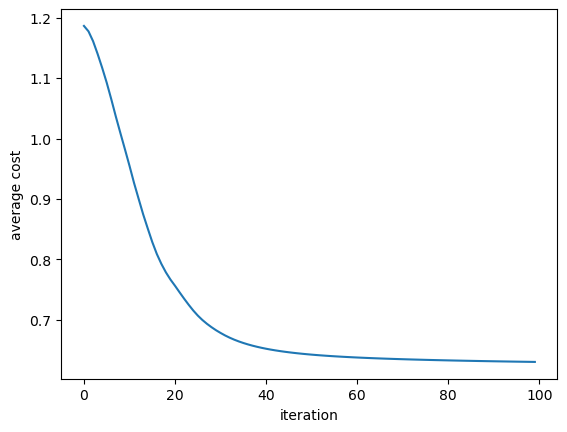

In [125]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results)
plt.xlabel('iteration')
plt.ylabel('average cost')
plt.show()

In [190]:
import cvxpy as cp
import tensorflow as tf
from cvxpylayers.tensorflow import CvxpyLayer

# Define and solve the CVXPY problem.
x = cp.Variable(
    cvector.shape[0],
    nonneg=True
)

pred = cp.Parameter((A.shape[0],))

problem = cp.Problem(
    cp.Minimize(cvector.T @ x),
    [
        A @ x == pred,
    ],
)
assert problem.is_dpp()
print(problem.parameters())

cvxpylayer = CvxpyLayer(
    problem,
    parameters=[pred],
    variables=[x])

rho_I=pdf1d(x_T, 4.0, 1.0).reshape(len(x_T),1)
rho_I = np.where(rho_I < 0, 0, rho_I)
rho_I = rho_I / np.sum(np.abs(rho_I))

y_pred = tf.Variable(tf.zeros((100,), tf.double))
y_pred = tf.constant(rho_I, shape=(100,))
rho_0_tf = tf.constant(rho_0, shape=(100,))

with tf.GradientTape() as tape:
  # solve the problem, setting the values of A, b to A_tf, b_tf
  param = tf.concat([rho_0_tf, y_pred], 0)
  x_sol, = cvxpylayer(param)
# compute the gradient of the summed solution with respect to A, b
grad_ypred = tape.gradient(x_sol, [y_pred])

print("x_sol")
print(x_sol)

print("grad_ypred")
print(grad_ypred)

print("problem.value", problem.value)

[Parameter((200,))]
x_sol
tf.Tensor(
[7.93610842e-08 7.95823100e-08 7.99275785e-08 ... 2.65252565e-09
 1.34670189e-09 3.34239356e-03], shape=(10000,), dtype=float64)
grad_ypred
[None]
problem.value None


In [193]:
print(cvector.T @ x_sol.numpy())

[0.63284935]
